In [11]:

import pandas as pd

In [21]:
pds = []

for _ in range(3):
	pds += [
		pd.DataFrame(
			{
				'numm':[1,2,3],
				'let': ['qwe', 'rt', 'asd']
			}
		)
	]

In [23]:
pd.concat(pds)

,numm,let
0,1,qwe
1,2,rt
2,3,asd
0,1,qwe
1,2,rt
2,3,asd
0,1,qwe
1,2,rt
2,3,asd


In [31]:
import os
import math
import numpy as np
import pandas as pd

from skfda import FDataGrid
from skfda.representation.basis import BSpline
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.registration import ElasticRegistration, landmark_registration

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth

from sklearn.metrics import (
	precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve, confusion_matrix
)
from keras import models
from tensorflow.keras import layers
import keras_tuner as kt

from matplotlib import pyplot as plt
import seaborn as sns

agg_columns = ['patient_id', 'slice_id', 'img_type']

n_basis=18
order=4

prc_rm=0.05
n_points=100

train_n_points = 10

basis = BSpline(domain_range=(0, 1), n_basis=n_basis, order=order)
smoother = BasisSmoother(basis=basis, return_basis=True, method='svd')

registration = ElasticRegistration()
ID = IntegratedDepth()
MBD = ModifiedBandDepth()

scaler = MinMaxScaler(feature_range=(0, 1), copy=False)


def cut_ends(bsplined, order=0, prc_rm_start=prc_rm, prc_rm_end=prc_rm, n_points=n_points):
	bsplined_grid = bsplined.derivative(order=order).to_grid(np.linspace(0, 1, n_points))
	return FDataGrid(
		data_matrix=bsplined_grid.data_matrix[
			..., int(n_points * prc_rm_start): int(n_points * (1 - prc_rm_end)), 0
		],
		grid_points=bsplined_grid.grid_points[0][
			int(n_points * prc_rm_start): int(n_points * (1 - prc_rm_end))
		]
	)


def get_landmark_registration(bsplined, order=0):
	bsplined_grid = cut_ends(bsplined, order)
	landmark_indexes = cut_ends(bsplined, order, prc_rm_end=0.5).data_matrix.argmax(axis=1)
	grid_points = bsplined_grid.grid_points[0]
	landmarks = [grid_points[index] for index in np.concatenate(landmark_indexes)]
	return landmark_registration(bsplined_grid, landmarks)


def get_descrete_points(fd_smooth):
	t_cut = np.linspace(
		start=0,
		stop=fd_smooth.data_matrix.shape[1] - 1,
		num=train_n_points, endpoint=True, dtype=int,
	)
	return fd_smooth.data_matrix[:, t_cut, 0]


def specificity(y_true, y_pred, zero_division=0):
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	if tn+fp == 0 and zero_division:
		return zero_division
	return tn / (tn+fp)



0
INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
1
558/558 [==============================] - 1s 2ms/step - loss: 0.0489 - accuracy: 0.6831 - val_loss: 0.6936 - val_accuracy: 0.0437
2
564/564 [==============================] - 2s 2ms/step - loss: 0.0517 - accuracy: 0.5882 - val_loss: 0.6942 - val_accuracy: 0.0343
3
536/536 [==============================] - 1s 2ms/step - loss: 0.0507 - accuracy: 0.7908 - val_loss: 0.6798 - val_accuracy: 0.9579
4
542/542 [==============================] - 1s 2ms/step - loss: 0.0512 - accuracy: 0.3464 - val_loss: 0.7090 - val_accuracy: 0.0351


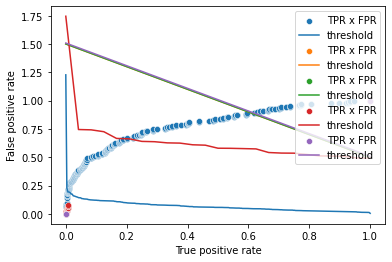

In [69]:
def build_model(level):
	model = models.Sequential()
	model.add(layers.Dense(2 ** level, input_dim=13, activation='relu'))
	for layer in reversed(range(1, level)):
		model.add(layers.Dense(2 ** layer, activation='relu'))

	model.add(layers.Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


def build_hp_model(hp):
	return build_model(hp.Int('level', 5, 9))


def kfolds(dataset, nfolds=5):
	class_ratios = (
		dataset
			.query('label')
			.patient_id
			.value_counts()
			.reset_index()
			.rename(
				{'patient_id': 'cancerous_regions', 'index': 'patient_id'},
				axis='columns',
			)
			.merge(
				dataset
					.patient_id
					.value_counts()
					.reset_index()
					.rename({'patient_id': 'n', 'index': 'patient_id'}, axis='columns')
			)
		.assign(patient_ratio=lambda x: x.cancerous_regions / x.n)
		.sort_values('patient_ratio', ascending=False)
		.assign(
			fold_id=lambda x:
				(
					(list(range(0, nfolds)) + list(reversed(range(0, nfolds)))) *
					math.ceil(x.shape[0] / (nfolds * 2))
				)
				[:x.shape[0]]
		)
	)
	return class_ratios.groupby('fold_id').patient_id.apply(list).to_numpy()


def train_kfolds(Y, X, folds, segmentation):
	ax = None
	f1s = []
	precisions = []
	recalls = []
	accuracies = []
	specificities = []

	train_f1s = []
	train_precisions = []
	train_recalls = []
	train_accuracies = []
	train_specificities = []

	patients = pd.DataFrame(X)[13]
	X = pd.DataFrame(
		np.vstack(
            pd.DataFrame(X).groupby([13]).apply(scaler.fit_transform).to_numpy()
        )[:,0:-1]
	).assign(Y=Y, patient=patients)
	
	
	for i, test_patients in enumerate(folds):
		print(i)
		X_train = X[X.patient.apply(lambda x: x not in test_patients)]
		X_test = X[X.patient.apply(lambda x: x in test_patients)]
		
		y_train = X_train.Y
		y_test = X_test.Y
		X_train = X_train.drop(['Y', 'patient'], axis='columns')
		X_test = X_test.drop(['Y', 'patient'], axis='columns')
		
		if i == 0:
			tuner = kt.BayesianOptimization(build_hp_model, 'loss', max_trials=5)
			tuner.search(
				x=X_train, y=y_train,
				class_weight=(1 - pd.Series(y_train).value_counts() / len(y_train)).to_dict(),
				validation_data=(X_test, y_test)
			)
			model = tuner.get_best_models(num_models=1)[0]
			best_hp = tuner.get_best_hyperparameters()[0]
		else:
			model = build_model(best_hp.get('level'))
			model.fit(
				X_train, y_train,
				class_weight=(1 - pd.Series(y_train).value_counts() / len(y_train)).to_dict(),
				validation_data=(X_test, y_test),
			)

		preds = model.predict(X_test)
		fpr, tpr, thresholds = roc_curve(y_test, preds)
		ax = sns.scatterplot(x=fpr, y=tpr, ax=ax)
		ax = sns.lineplot(x=np.linspace(0, 1, len(thresholds)), y=thresholds)

		preds = np.reshape(preds >= 0.5, (-1)).astype(int)

		f1s += [f1_score(y_test, preds, zero_division=0)]
		precisions += [precision_score(y_test, preds, zero_division=0)]
		recalls += [recall_score(y_test, preds, zero_division=0)]
		accuracies += [balanced_accuracy_score(y_test, preds)]
		specificities += [specificity(y_test, preds)]

		preds = np.reshape(model.predict(X_train) >= 0.5, (-1)).astype(int)
		train_f1s += [f1_score(y_train, preds, zero_division=0)]
		train_precisions += [precision_score(y_train, preds, zero_division=0)]
		train_recalls += [recall_score(y_train, preds, zero_division=0)]
		train_accuracies += [balanced_accuracy_score(y_train, preds)]
		train_specificities += [specificity(y_train, preds)]
	
	ax.set_ylabel('False positive rate')
	ax.set_xlabel('True positive rate')
	plt.legend(labels=['TPR x FPR', 'threshold'] * 5)
	plt.savefig(f'./roc/nn_segmentation-{segmentation}.png')
	return (
		segmentation,
		np.mean(f1s),
		np.mean(precisions),
		np.mean(recalls),
		np.mean(accuracies),
		np.mean(specificities),
		
		np.mean(train_f1s),
		np.mean(train_precisions),
		np.mean(train_recalls),
		np.mean(train_accuracies),
		np.mean(train_specificities),
	)


plt.close()
pd.DataFrame(
	[train_kfolds(labels, train_set, kfolds(dataset, 5), segmentation_id)],
	columns=[
		'segmentation', 'F1', 'precision', 'recall', 'accuracy', 'specificity',
		'train_F1', 'train_precision', 'train_recall', 'train_accuracy', 'train_specificity',
	]
).to_csv('nn_metrics_v3.csv', index=False, mode='a', header=False)

In [ ]:
# for segmentation_id in range(0, 25):
for segmentation_id in [4]:
	file = f'./segmentations/segmentation-{segmentation_id}.csv'
	dataset = (
		pd.read_csv(
			file,
			dtype={
				'img_type': int,
				'patient_id': int,
				'cycle_id': int,
				'slice_id': int,
				'label': bool,
				'mask_int_mean': float,
				'segment': int,
			},
		)
			.drop_duplicates()
			.sort_values(agg_columns + ['cycle_id'])
	)
	dataset = dataset[dataset.patient_id.apply(lambda x: x not in [3, 6, 7, 8, 10, 11, 14, 19, 27, 29, 37, 60, 66, 76, 86, 108, 119, 122, 123, 128, 133, 140])]
	dataset = dataset.merge(dataset.query('label').patient_id.drop_duplicates())
	ts = (
		dataset[['patient_id', 'cycle_id']].drop_duplicates()
			.groupby('patient_id').cycle_id.count()
			.apply(lambda x: np.linspace(0, 1, int(x)))
			.reset_index()
	)

	dataset = dataset.groupby(agg_columns + ['label']).mask_int_mean.apply(list).reset_index()
	bsplined = dataset.groupby('patient_id').mask_int_mean.apply(list).reset_index().merge(ts)
	bsplined = bsplined.apply(
		lambda x: smoother.fit_transform(
			FDataGrid(data_matrix=x['mask_int_mean'], grid_points=x['cycle_id'])
		),
		axis='columns',
	)
	print('registering ...')
	bsplined = [get_landmark_registration(fd_smooth, 1) for fd_smooth in bsplined]
	print('getting depths ...')
	ids = np.vstack([ID(fd_smooth).reshape(-1, 1) for fd_smooth in bsplined])
	mbds = np.vstack([MBD(fd_smooth).reshape(-1, 1) for fd_smooth in bsplined])
	print('getting other features ...')
	max_values = np.vstack(
		[fd_smooth.data_matrix.max(axis=1).reshape(-1, 1) for fd_smooth in bsplined]
	)
	descret_points = np.vstack([get_descrete_points(fd_smooth) for fd_smooth in bsplined])
	patients = dataset.patient_id.to_numpy().reshape(-1, 1)

	train_set = np.hstack([ids, mbds, max_values, descret_points, patients])
	labels = dataset.label.astype(int).to_numpy()


	pd.DataFrame(
		[train_kfolds(labels, train_set, kfolds(dataset, 5), segmentation_id)],
		columns=[
			'segmentation', 'F1', 'precision', 'recall', 'accuracy', 'specificity',
			'train_F1', 'train_precision', 'train_recall', 'train_accuracy', 'train_specificity',
		]
	).to_csv('nn_metrics_v3.csv', index=False, mode='a', header=False)

In [23]:

patients = pd.DataFrame(train_set)[13]
X = pd.DataFrame(
	np.vstack(pd.DataFrame(train_set).groupby(13).apply(scaler.fit_transform).to_numpy())
		[:,0:-1]
).assign(Y=labels, patient=patients).query('patient == 50')

y_train = X.Y
X_train = X.drop(['Y', 'patient'], axis='columns')


In [24]:

nn_model = models.Sequential()
nn_model.add(layers.Dense(128, input_dim=13, activation='relu'))
nn_model.add(layers.Dense(64, activation='relu'))
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.Dense(16, activation='relu'))
nn_model.add(layers.Dense(8, activation='relu'))
nn_model.add(layers.Dense(4, activation='relu'))
nn_model.add(layers.Dense(2, activation='relu'))
nn_model.add(layers.Dense(1, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nn_model.fit(
	X_train, y_train,
	class_weight=(1 - pd.Series(y_train).value_counts() / len(y_train)).to_dict(),
	epochs=1
)
preds = nn_model.predict(X_train)


40/40 [==============================] - 0s 876us/step - loss: 0.0683 - accuracy: 0.2230


In [57]:
np.unique(res)

array([0.00000000e+00, 1.68208579e-03, 2.52312868e-03, 3.36417157e-03,
       4.20521447e-03, 5.88730025e-03, 7.56938604e-03, 1.17746005e-02,
       1.26156434e-02, 1.40845070e-02, 2.60723297e-02, 2.94365013e-02,
       3.19596299e-02, 4.03700589e-02, 4.45752733e-02, 5.55088310e-02,
       6.30782170e-02, 8.41042893e-02, 8.99915896e-02, 1.04289319e-01,
       1.09335576e-01, 1.39613120e-01, 1.48864592e-01, 1.69049622e-01,
       1.73254836e-01, 1.93439865e-01, 2.08578638e-01, 2.11101766e-01,
       2.67605634e-01, 2.77544155e-01, 3.87720774e-01, 4.36619718e-01,
       4.50704225e-01, 4.92957746e-01, 4.98220950e-01, 4.98259842e-01,
       5.07042254e-01, 5.18372297e-01, 5.18464983e-01, 5.37426409e-01,
       5.47343969e-01, 5.47736585e-01, 5.67932427e-01, 5.68038881e-01,
       5.68780065e-01, 5.69059312e-01, 5.74559689e-01, 5.74754953e-01,
       5.77464789e-01, 5.83308399e-01, 5.83668172e-01, 5.85016429e-01,
       5.85403740e-01, 5.93372226e-01, 5.93606770e-01, 5.99357009e-01,
      

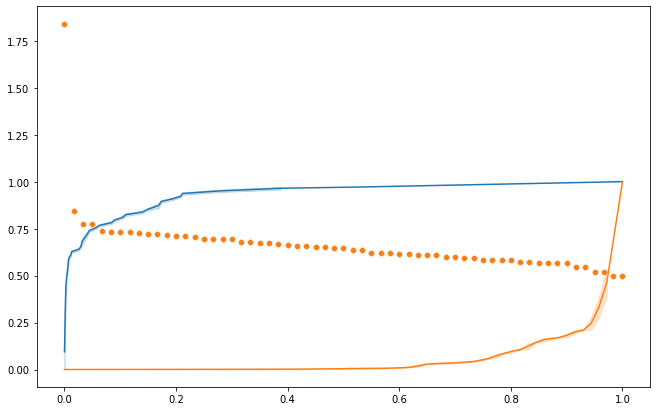

In [44]:

fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)


ax = sns.lineplot(x=res[0], y=res[1])
ax = sns.scatterplot(x=np.linspace(0, 1, len(res[2])), y=res[2])
ax = sns.lineplot(x=res[1], y=res[0], ax=ax)
ax = sns.scatterplot(x=np.linspace(0, 1, len(res[2])), y=res[2])


In [ ]:
f1_score(y_test, preds, zero_division=0)
precisions += [precision_score(y_test, preds, zero_division=0)]
recalls += [recall_score(y_test, preds, zero_division=0)]
accuracies += [balanced_accuracy_score(y_test, preds)]
specificities += [specificity(y_test, preds)]

preds = model.predict(X_train)
train_f1s += [f1_score(y_train, preds, zero_division=0)]
train_precisions += [precision_score(y_train, preds, zero_division=0)]
train_recalls += [recall_score(y_train, preds, zero_division=0)]
train_accuracies += [balanced_accuracy_score(y_train, preds)]
train_specificities += [specificity(y_train, preds)]
